In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
path = "C:\\Users\\AjayKrishnan\\OneDrive - ADA Global\\Desktop\\face_data\\UTKFace\\"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [3]:
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    image = np.array(image)
    images.append(image)
    split_var = file.split('_')
    ages.append(int(split_var[0]))
    genders.append(int(split_var[1]) )

In [4]:
len(images),len(ages),len(genders)

(23708, 23708, 23708)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
images = pd.Series(list(images), name = 'images')
ages = pd.Series(list(ages), name = 'ages')
genders = pd.Series(list(genders), name = 'genders')

In [7]:
df = pd.concat([images, ages, genders], axis=1)


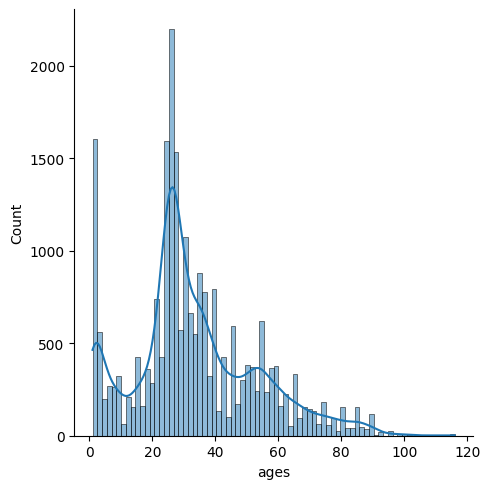

In [8]:
import seaborn as sns
sns.displot(df['ages'], kde = True)

In [9]:
# sns.displot(df['ages'], kde = True)

In [10]:
#model


In [11]:
images = df['images'].tolist()
images = np.array(images)

ages = df['ages'].tolist()
ages = np.array(ages)

genders = df['genders'].tolist()
genders = np.array(genders)


target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,images.shape[1],images.shape[2],1),dtype = 'float32')
for i in range(size):
    target[i,0] = int(ages[i])
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
# display(features[550])


In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)

In [19]:
# from keras.applications.vgg16 import VGG16
# conv_model=VGG16(weights='imagenet',include_top=False,input_shape=(64,64,3))

In [20]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

In [21]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [22]:
# inputs = Input(shape=(64,64,1))
# conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
# conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# x = Dropout(0.25)(pool2)
# flat = Flatten()(x)

# dropout = Dropout(0.5)

# age_model = Dense(64, activation='relu')(flat)
# age_model = dropout(age_model)
# age_model = Dense(1, activation='relu')(age_model)

# dropout = Dropout(0.5)

# gender_model = Dense(32, activation='relu')(flat)
# gender_model = dropout(gender_model)
# gender_model = Dense(1, activation='sigmoid')(gender_model)

In [27]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])

model.compile(
    optimizer='adam',
    loss={'dense_2': 'mse', 'dense_5': 'binary_crossentropy'},  # Use the correct output layer names
    metrics={'dense_2': ['mae'], 'dense_5': ['accuracy']}  # Metrics for age and gender outputs
)

# model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [28]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 64, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 62, 62, 32)        │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 60, 60, 64)        │          18,496 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 30, 30, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 28, 28, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 14, 14, 128)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 14, 14, 128)       │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 25088)             │               0 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │       3,211,392 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 128)               │       3,211,392 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ dense[0][0], dense_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32)                │               0 │ dense_3[0][0],             │
│                               │                           │                 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 32)                │           4,128 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              65 │ dropout_1[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │              33 │ dropout_2[1][0]            │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 6,527,938 (24.90 MB)

 Trainable params: 6,527,938 (24.90 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
print(model.output_names)

ListWrapper(['dense_2', 'dense_5'])


In [30]:
history = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

Epoch 1/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - dense_2_mae: 19.8247 - dense_5_accuracy: 0.5329 - loss: 654.8315 - val_dense_2_mae: 13.2277 - val_dense_5_accuracy: 0.6995 - val_loss: 320.1529
Epoch 2/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 465s 3s/step - dense_2_mae: 13.8488 - dense_5_accuracy: 0.6682 - loss: 330.0607 - val_dense_2_mae: 10.7355 - val_dense_5_accuracy: 0.7760 - val_loss: 198.6647
Epoch 3/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - dense_2_mae: 12.3211 - dense_5_accuracy: 0.7240 - loss: 264.9857 - val_dense_2_mae: 10.2121 - val_dense_5_accuracy: 0.8170 - val_loss: 186.6718
Epoch 4/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - dense_2_mae: 11.2570 - dense_5_accuracy: 0.7555 - loss: 221.8445 - val_dense_2_mae: 8.4936 - val_dense_5_accuracy: 0.8281 - val_loss: 130.2766
Epoch 5/25
149/149 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - dense_2_mae: 10.4661 - dense_5_accuracy: 0.7663 - loss: 196.6841 - val_dense_2_mae: 8.2158 - val_dense_5_accuracy: 0.8524 - val_loss: 122.7608
Epoch 6

In [33]:
model.save('face.h5')

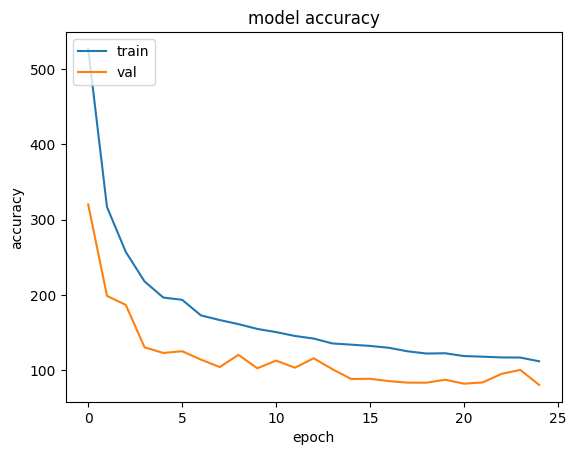

In [34]:
# history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
# k = np.expand_dims(x_test[0],axis=0)
k = x_test[0]
k.shape

(64, 64, 1)

In [60]:
model.predict(np.expand_dims(k,axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[array([[41.28869]], dtype=float32), array([[0.04680434]], dtype=float32)]

In [64]:
model.save('my_model.h5')

## Detection

In [66]:
import cv2
import matplotlib.pyplot as plt

In [67]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [77]:
img = cv2.imread("C:\\Users\\AjayKrishnan\\OneDrive - ADA Global\\Desktop\\face_data\\Mcu2.jpg")

In [78]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [79]:
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

In [80]:
# # Draw rectangle around the faces
# for (x, y, w, h) in faces:
#     cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# # Display the output
# plt.figure(figsize=(10, 6))
# plt.imshow(img_rgb)
# plt.axis('off')  # Hide the axis
# plt.show()

In [138]:
for i, (x, y, w, h) in enumerate(faces):
    # Crop the face from the image
    expand = 40

    x_new = max(x - expand, 0)
    y_new = max(y - expand, 0)
    w_new = min(x + w + expand, img.shape[1]) - x_new
    h_new = min(y + h + expand, img.shape[0]) - y_new
    
    # Crop the face from the image with the expanded bounding box
    face_img = img[y_new:y_new + h_new, x_new:x_new + w_new]

    
    # face_img = img[y:y + h, x:x + w]
    # Define a filename for the cropped face
    face_filename = os.path.join(output_folder, f'face_{i+1}.jpg')
    
    # Save the cropped face
    cv2.imwrite(face_filename, face_img)


In [139]:
#showing th epics

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


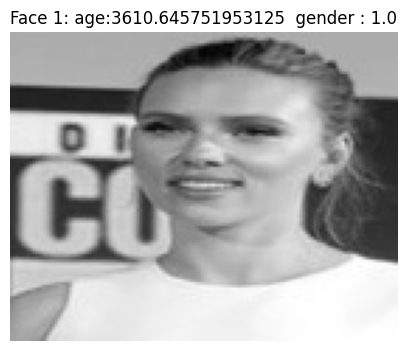

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


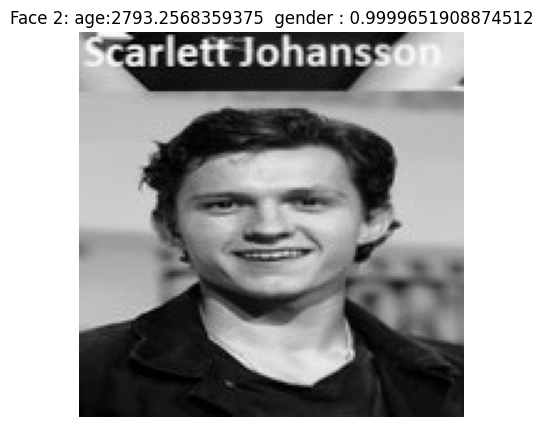

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


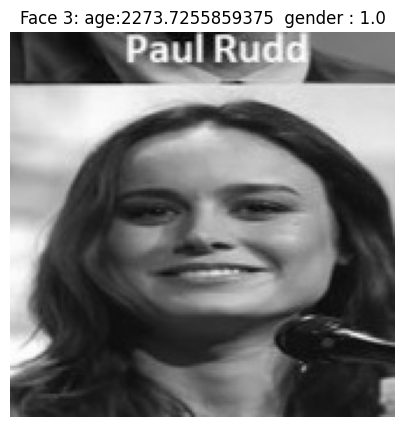

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


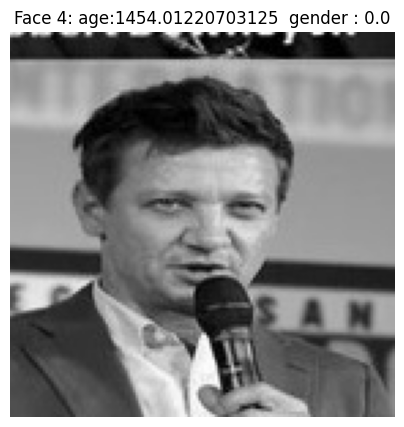

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


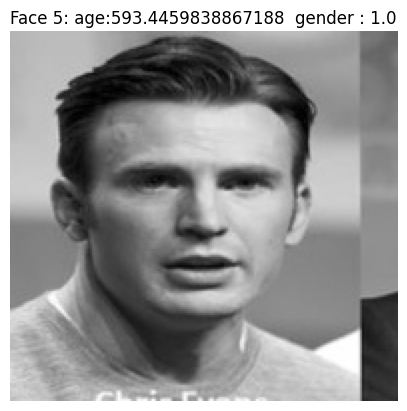

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


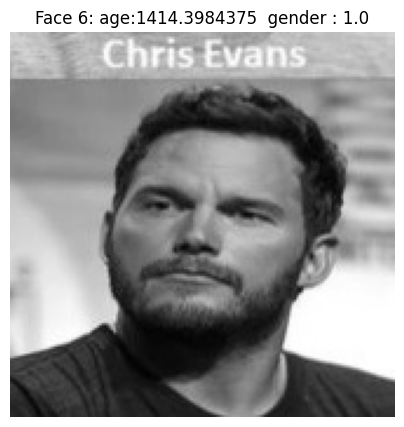

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


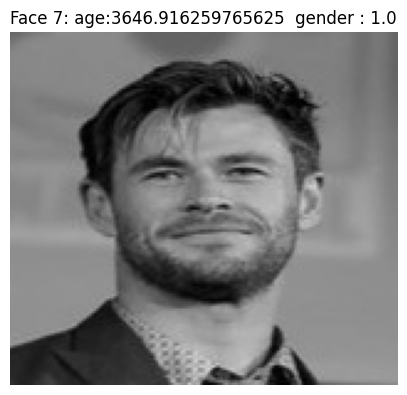

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


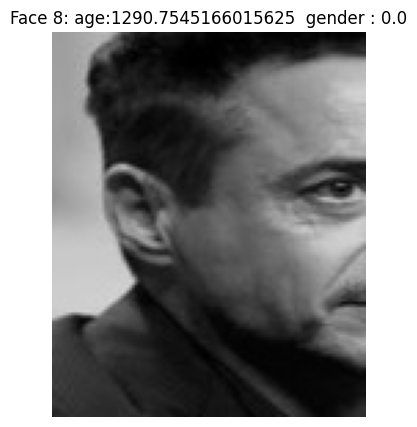

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


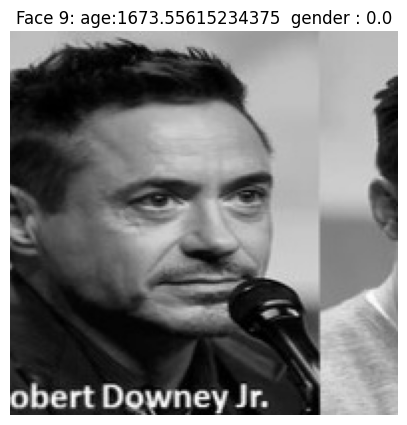

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


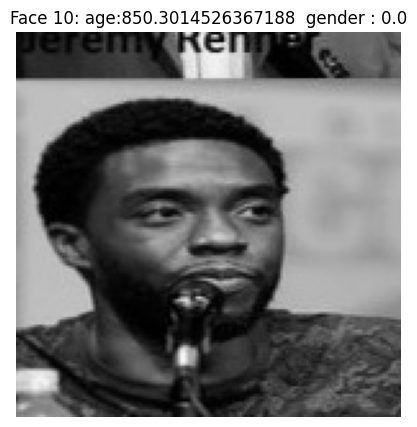

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


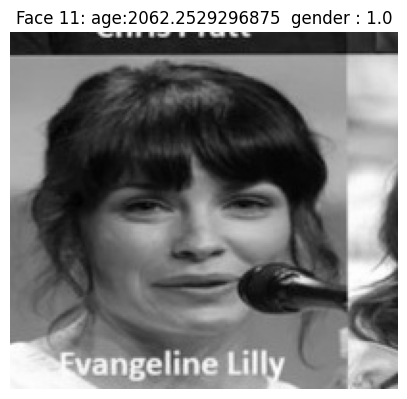

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


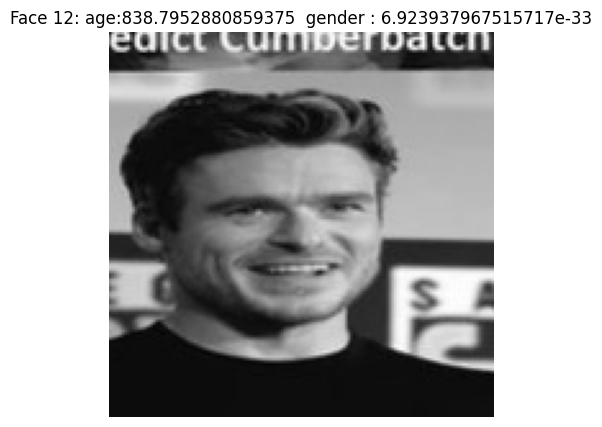

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


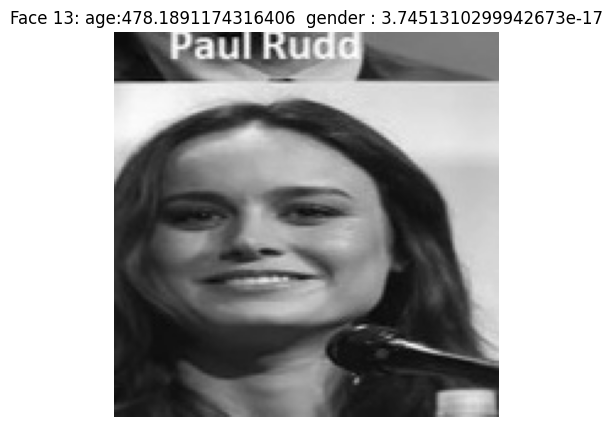

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


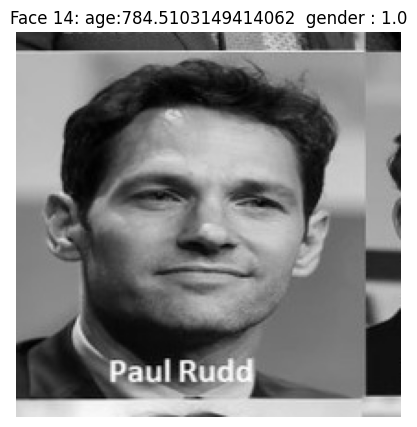

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


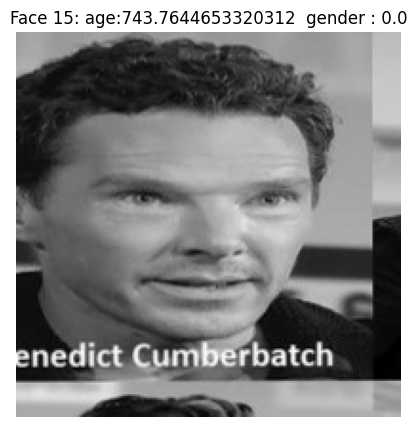

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


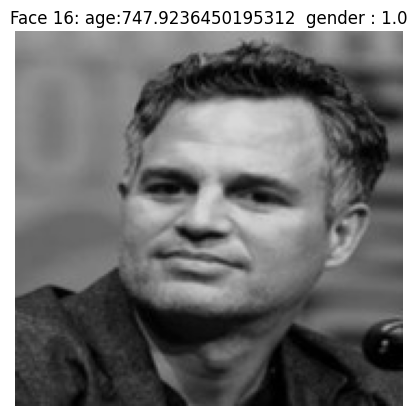

In [143]:
for i, (x, y, w, h) in enumerate(faces):
    image = cv2.imread(os.path.join(output_folder, f'face_{i+1}.jpg'), 0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    image = np.array(image)
    answer = model.predict(np.expand_dims(image,axis=0))

    face_image = cv2.imread(os.path.join(output_folder, f'face_{i+1}.jpg'), 0)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Face {i+1}: age:{answer[0][0][0]}  gender : {answer[1][0][0]}')
    plt.show()

In [114]:
answer = model.predict(np.expand_dims(image,axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [116]:
answer

[array([[518.5809]], dtype=float32), array([[0.]], dtype=float32)]

In [126]:
answer[0][0][0], answer[1][0][0]

(518.5809, 0.0)

0.0